In [1]:
from PIL import Image
import cv2
import numpy as np
from skimage.morphology import disk, skeletonize, remove_small_objects, binary_opening
from skimage.filters.rank import autolevel, median
import matplotlib.pyplot as plt

In [2]:
# URL of the file
url = "https://github.com/lonespear/aerogel/raw/main/aerogel_co_50mM_magnet_0016.tif"

# Download the file using wget
!wget {url} -O aerogel_co_50mM_magnet_0016.tif

file_path = f"aerogel_co_50mM_magnet_0016.tif"
og_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
fib_image = og_img # Removing data ribbon at bottom

--2024-10-21 13:06:14--  https://github.com/lonespear/aerogel/raw/main/aerogel_co_50mM_magnet_0016.tif
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lonespear/aerogel/main/aerogel_co_50mM_magnet_0016.tif [following]
--2024-10-21 13:06:15--  https://raw.githubusercontent.com/lonespear/aerogel/main/aerogel_co_50mM_magnet_0016.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21013560 (20M) [application/octet-stream]
Saving to: ‘aerogel_co_50mM_magnet_0016.tif’

aerogel_co_50mM_mag 100%[===================>]  20.04M  --.-KB/s    in 0.1s    

2024-10-21 13:06:15 (142 MB/s) - ‘aerogel_co_50mM_mag

In [22]:
# Preprocessing image functions taken from https://github.com/drewvecchio/StructuralGT/blob/master/StructuralGT/process_image.py

def adjust_gamma(image, gamma):
    if(gamma != 1.00):
        invGamma = 1.00/gamma
        table = np.array([((i/255.0) ** invGamma) * 255 \
                          for i in np.arange(0,256)]).astype('uint8')
        return cv2.LUT(image,table)
    else:
        return image

def Hamming_window(image, windowsize):
    w, h = image.shape
    ham1x = np.hamming(w)[:, None]  # 1D hamming
    ham1y = np.hamming(h)[:, None]  # 1D hamming
    ham2d = np.sqrt(np.dot(ham1x, ham1y.T)) ** windowsize  # expand to 2D hamming
    f = cv2.dft(image.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
    f_shifted = np.fft.fftshift(f)
    f_complex = f_shifted[:, :, 0] * 1j + f_shifted[:, :, 1]
    f_filtered = ham2d * f_complex
    f_filtered_shifted = np.fft.fftshift(f_filtered)
    inv_img = np.fft.ifft2(f_filtered_shifted)  # inverse F.T.
    filtered_img = np.abs(inv_img)
    filtered_img -= filtered_img.min()
    filtered_img = filtered_img * 255 / filtered_img.max()
    filtered_img = filtered_img.astype(np.uint8)
    return filtered_img

def thresh_it(image, Threshtype, fg_color, asize, thresh):

    # only needed for OTSU threshold
    ret = 0

    # applying universal threshold, checking if it should be inverted (dark foreground)
    if(Threshtype ==0):
        if(fg_color ==1):
            img_bin = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY_INV)[1]
        else:
            img_bin = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)[1]

    # adaptive threshold generation
    elif(Threshtype ==1 ):
        if (fg_color == 1):
            img_bin = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, asize, 2)
        else:
            img_bin = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, asize, 2)

    #OTSU threshold generation
    elif (Threshtype == 2):
        if (fg_color == 1):
            img_bin = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
            ret = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[0]
        else:
            img_bin = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
            ret = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]

    return img_bin, ret

def binarize(source, Threshtype, gamma, md_filter, g_blur, autolvl, fg_color, \
             laplacian, scharr, sobel, lowpass, asize, bsize, wsize, thresh):
    img = source
    img = adjust_gamma(img, gamma)

    # applies a low-pass filter
    if(lowpass ==1):
        img = Hamming_window(img, wsize)


    # making a 5x5 array of all 1's for median filter, and a disk for the autolevel filter
    darray = np.zeros((5, 5)) + 1
    selem = disk(11)

    # applying median filter
    if (md_filter == 1):
        img = median(img, darray)

    # applying gaussian blur
    if (g_blur == 1):
        img = cv2.GaussianBlur(img, (bsize, bsize), 0)

    # applying autolevel filter
    if (autolvl == 1):
        img = autolevel(img, selem)

    # applying a scharr filter, and then taking that image and weighting it 25% with the original
    # this should bring out the edges without separating each "edge" into two separate parallel ones
    if (scharr == 1):
        ddepth = cv2.CV_16S
        grad_x = cv2.Scharr(img, ddepth, 1, 0)
        grad_y = cv2.Scharr(img, ddepth, 0, 1)
        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)
        dst = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
        dst = cv2.convertScaleAbs(dst)
        img = cv2.addWeighted(img, 0.75, dst, 0.25, 0)
        img = cv2.convertScaleAbs(img)

    # applying sobel filter
    if (sobel == 1):
        scale = 1;
        delta = 0;
        ddepth = cv2.CV_16S
        grad_x = cv2.Sobel(img, ddepth, 1, 0, ksize=7, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        grad_y = cv2.Sobel(img, ddepth, 0, 1, ksize=7, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)
        dst = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
        dst = cv2.convertScaleAbs(dst)
        img = cv2.addWeighted(img, 0.75, dst, 0.25, 0)
        img = cv2.convertScaleAbs(img)

    # applying laplacian filter
    if (laplacian == 1):
        ddepth = cv2.CV_16S
        dst = cv2.Laplacian(img, ddepth, ksize=11)

        # dst = cv2.Canny(img, 100, 200); # canny edge detection test
        dst = cv2.convertScaleAbs(dst)
        img = cv2.addWeighted(img, 0.75, dst, 0.25, 0)
        img = cv2.convertScaleAbs(img)

    # this is my attempt at a fast fourier transformation with a band pass filter
    # I would highly reccomend taking a look at this and seeing if its working right
    # I had no idea what I was doing but I think it works, it could use some more testing because it just
    # kinda makes the image blurry, but that could be the band pass filter
    #if fourier == 1:

        #rows, cols = img.shape
        #m = cv2.getOptimalDFTSize(rows)
        #n = cv2.getOptimalDFTSize(cols)
        #padded = cv2.copyMakeBorder(img, 0, m - rows, 0, n - cols, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        #planes = [np.float32(padded), np.zeros(padded.shape, np.float32)]
        #complexI = cv2.merge(planes)
        #dft = cv2.dft(np.float32(complexI), flags=cv2.DFT_COMPLEX_OUTPUT)
        #dft_shift = np.fft.fftshift(dft)

        # Band pass filter mask

        #rows, cols = img.shape
        #crow, ccol = int(rows / 2), int(cols / 2)

        #mask = np.zeros((rows, cols, 2), np.uint8)
        #r_out = 80
        #r_in = 10
        #center = [crow, ccol]
        #x, y = np.ogrid[:rows, :cols]
        #mask_area = np.logical_and(((x - center[0]) ** 2 + (y - center[1]) ** 2 >= r_in ** 2),
                                   #((x - center[0]) ** 2 + (y - center[1]) ** 2 <= r_out ** 2))
        #mask[mask_area] = 1

        # apply mask and inverse DFT
        #fshift = dft_shift * mask

        #f_ishift = np.fft.ifftshift(fshift)
        #img_back = cv2.idft(f_ishift)
        #img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
        #cv2.normalize(img_back, img_back, 0, 255, cv2.NORM_MINMAX)
        #img = cv2.convertScaleAbs(img_back)

    img_bin, ret = thresh_it(img, Threshtype, fg_color, asize, thresh)
    skel = skeletonize(img_bin)
    # cleaned_skeleton = remove_small_objects(skel, min_size=20)
    return img, img_bin, skel, ret

def see_plots(source=fib_image, Threshtype=1, gamma=1, md_filter=1, g_blur=1, autolvl=1, fg_color=0, laplacian=1, scharr=1, sobel=1, lowpass=1, asize=3, bsize=11, wsize=5, thresh=160):
    result, img_bin, skel, ret = binarize(source=source, Threshtype=Threshtype, gamma=gamma, md_filter=md_filter, g_blur=g_blur, autolvl=autolevel, fg_color=fg_color, laplacian=laplacian,
                                          scharr=scharr, sobel=sobel, lowpass=lowpass, asize=asize, bsize=bsize, wsize=wsize, thresh=thresh)

    plt.figure(figsize=(20, 10))  # Create a figure with a custom size

    plt.subplot(1,4,1)
    plt.imshow(source, cmap='gray')
    plt.title('Orignial Image')
    plt.axis('on')

    # Plot the blurred image
    plt.subplot(1, 4, 2)  # (rows, columns, index) -> this creates a 1x2 grid, first position
    plt.imshow(result, cmap='gray')
    plt.title('Blurred Image')
    plt.axis('on')

    # Plot the binarized image
    plt.subplot(1, 4, 3)  # (rows, columns, index) -> this creates a 1x2 grid, first position
    plt.imshow(img_bin, cmap='gray')
    plt.title('Binarized Image')
    plt.axis('on')

    # Plot the skeletonized image
    plt.subplot(1, 4, 4)  # This creates a 1x2 grid, second position
    plt.imshow(skel, cmap='gray')
    plt.title('Skeletonized Image')
    plt.axis('on')

    # Display the plot
    plt.tight_layout()
    plt.show()


In [23]:
tst_fib = fib_image[0:256, 0:256]

### Argument Presets to Below:
+ source: the image variable
+ Threshtype: either 0, 1, or 2
+ gamma: generally between 0 and 2 (1 doesn't do anthing)
+ md_filter: median filter on or off (1 or 0)
+ g_blur: Gaussian blur on or off (1 or 0)
+ autolvl: Autolevel filter on or off (1 or 0)
+ fg_color: foreground or background on or off (1 or 0)
+ laplacian: Laplacian filter on or off (1 or 0) ***Takes 2nd partial derivative for x and y directions and adds them*** https://docs.opencv.org/4.x/d5/db5/tutorial_laplace_operator.html
+ scharr: yet another operator  (1 or 0)... Scharr this time *** https://docs.opencv.org/4.x/d5/d0f/tutorial_py_gradients.html ***
+ sobel: and yet still another filter operator... (1 or 0)
+ lowpass: another filter (1 or 0)
+ asize: adaptive threshold blur parameter, needs to be odd
+ bsize: gaussian blur parameter, needs to be odd
+ wsize: Hamming window parameter, needs to be odd
+ thresh: universal threshold parameter (0 to 255)

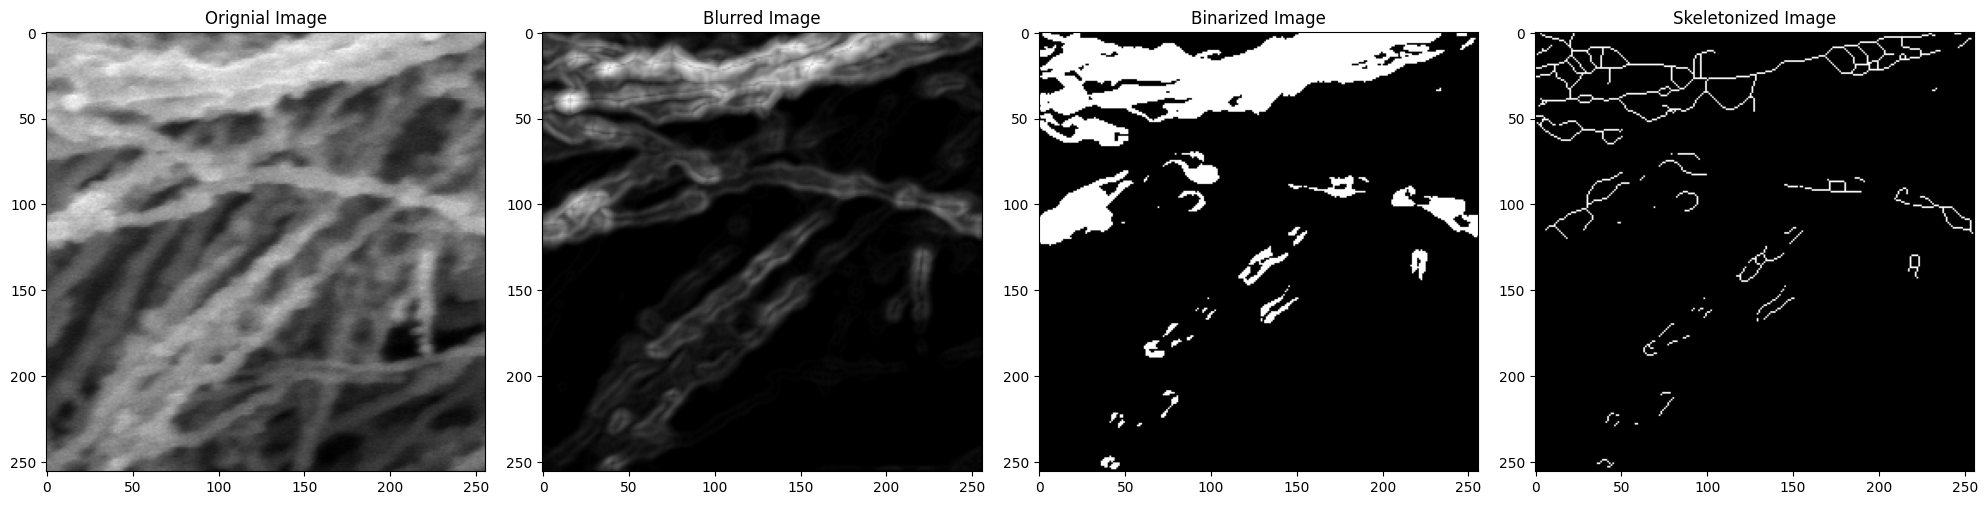

In [49]:
see_plots(source=tst_fib, Threshtype=2, gamma=0.2, md_filter=1, g_blur=1, autolvl=1, fg_color=0, laplacian=0, scharr=1, sobel=0, lowpass=1, asize=3, bsize=3, wsize=3, thresh=250)

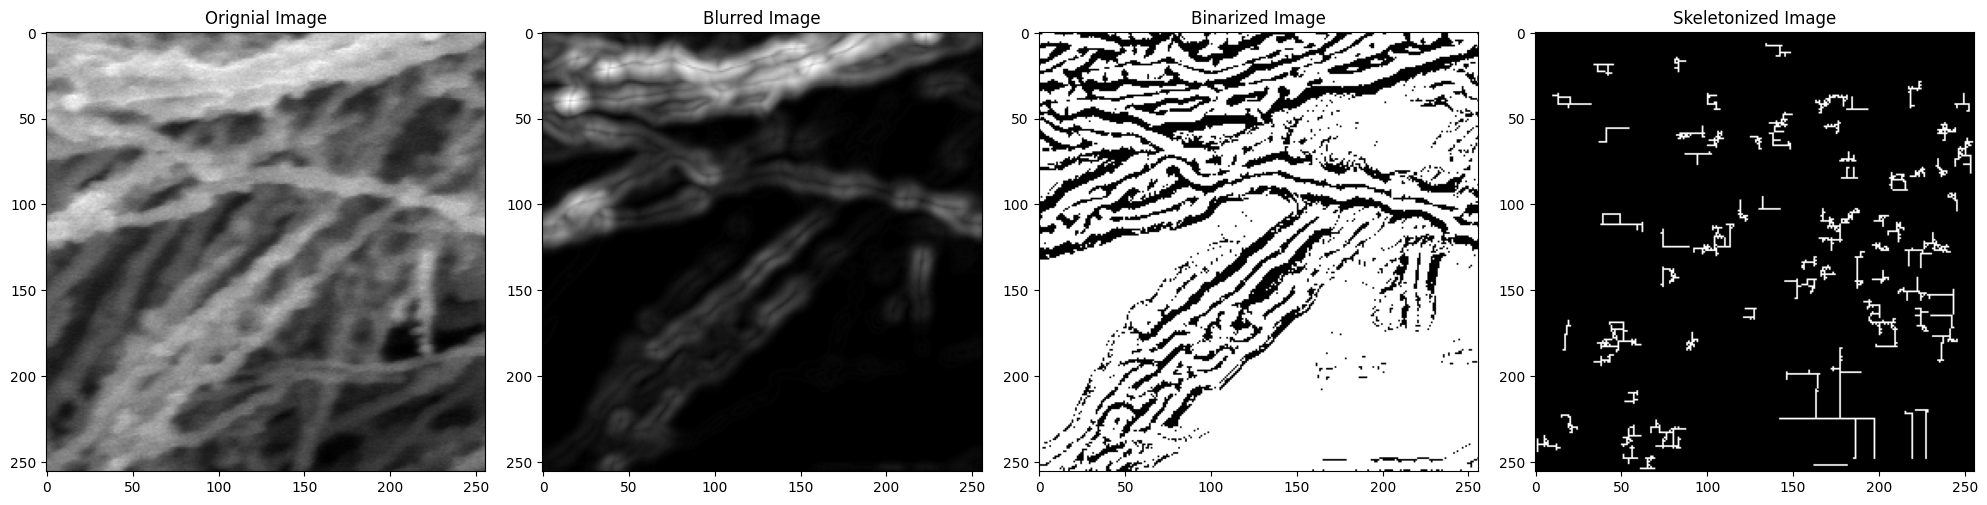

In [6]:
see_plots(source=tst_fib, Threshtype=1, gamma=0.2, md_filter=1, g_blur=1, autolvl=1, fg_color=0, laplacian=0, scharr=1, sobel=0, lowpass=1, asize=11, bsize=11, wsize=5, thresh=190)

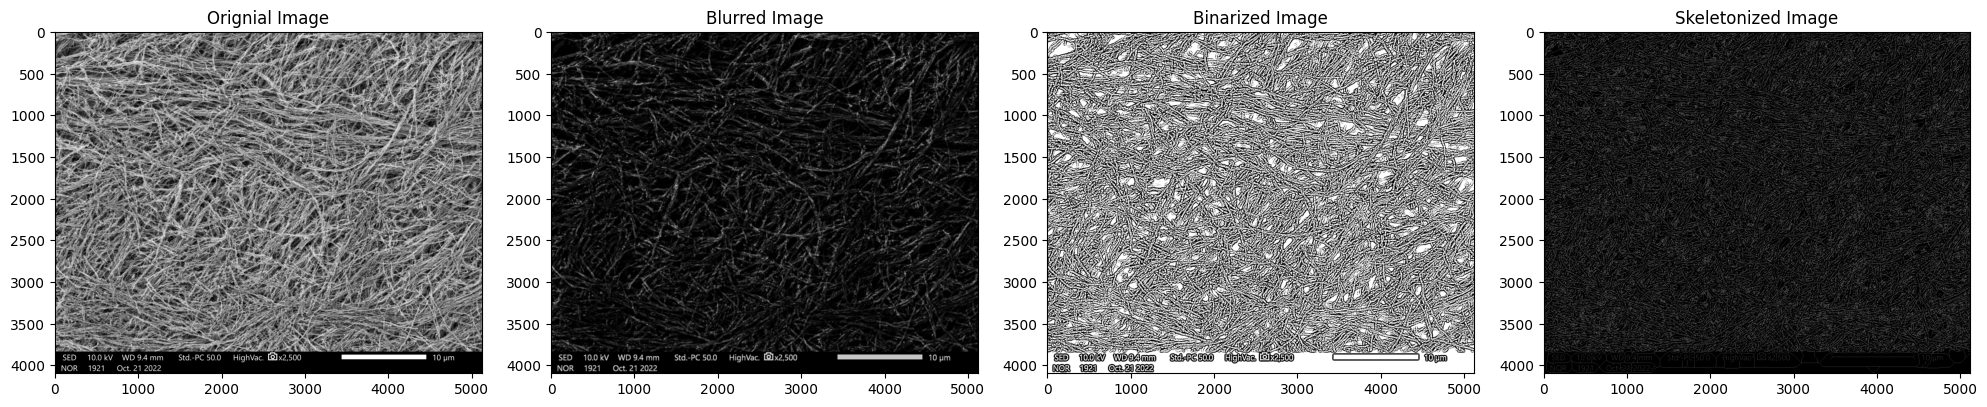

In [ ]:
see_plots(source=tst_fib, Threshtype=1, gamma=0.2, md_filter=1, g_blur=1, autolvl=1, fg_color=0, laplacian=0, scharr=1, sobel=0, lowpass=1, asize=35, bsize=11, wsize=5, thresh=190)

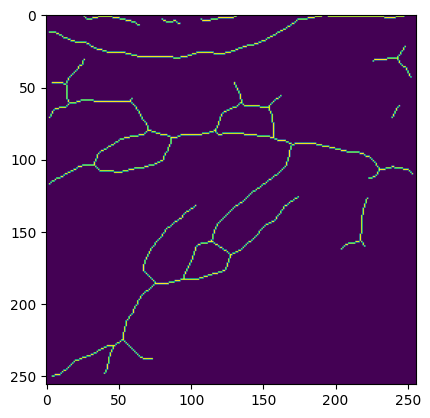

In [79]:
# Threshold the image
ret,img = cv2.threshold(tst_fib, 127, 255, 0)

# Step 1: Create an empty skeleton
size = np.size(img)
skel = np.zeros(img.shape, np.uint8)

# Get a Cross Shaped Kernel
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

# making a 5x5 array of all 1's for median filter, and a disk for the autolevel filter
darray = np.zeros((5, 5)) + 1
selem = disk(11)

# Repeat steps 2-4
while True:
    #Step 2: Open the image
    open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
    #Step 3: Subtract open from the original image
    temp = cv2.subtract(img, open)
    #Step 4: Erode the original image and refine the skeleton
    eroded = cv2.erode(img, element)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
    # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
    if cv2.countNonZero(img)==0:
        break

img = cv2.GaussianBlur(skel, (25, 25), 0)
# img = median(img, darray)
# img = autolevel(img, selem)
_, bin_img = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
# bin_img = cv2.Laplacian(bin_img, cv2.CV_16S, ksize=11)
skel_img = skeletonize(bin_img)
plt.imshow(skel_img)

array([[151, 160, 158, ..., 167, 172, 164],
       [179, 186, 165, ..., 168, 162, 158],
       [175, 178, 178, ..., 160, 154, 155],
       ...,
       [122, 122, 116, ..., 100,  98,  90],
       [124, 120, 124, ...,  85,  80,  88],
       [120, 122, 122, ...,  84,  80,  71]], dtype=uint8)
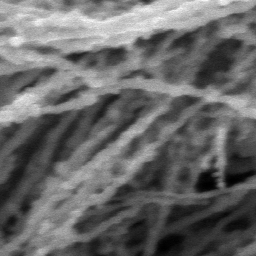

In [55]:
tst_fib

array([[255,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)
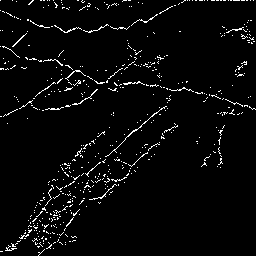

In [67]:
skel

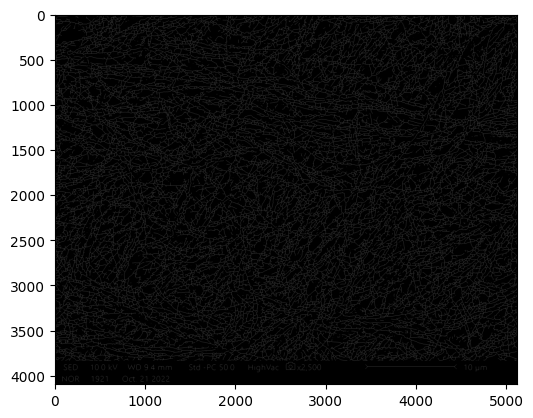

In [81]:
# Threshold the image
ret,img = cv2.threshold(fib_image, 127, 255, 0)

# Step 1: Create an empty skeleton
size = np.size(img)
skel = np.zeros(img.shape, np.uint8)

# Get a Cross Shaped Kernel
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

# making a 5x5 array of all 1's for median filter, and a disk for the autolevel filter
darray = np.zeros((5, 5)) + 1
selem = disk(11)

# Repeat steps 2-4
while True:
    #Step 2: Open the image
    open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
    #Step 3: Subtract open from the original image
    temp = cv2.subtract(img, open)
    #Step 4: Erode the original image and refine the skeleton
    eroded = cv2.erode(img, element)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
    # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
    if cv2.countNonZero(img)==0:
        break

img = cv2.GaussianBlur(skel, (25, 25), 0)
# img = median(img, darray)
# img = autolevel(img, selem)
_, bin_img = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
# bin_img = cv2.Laplacian(bin_img, cv2.CV_16S, ksize=11)
skel_img = skeletonize(bin_img)
plt.imshow(skel_img, cmap='gray')

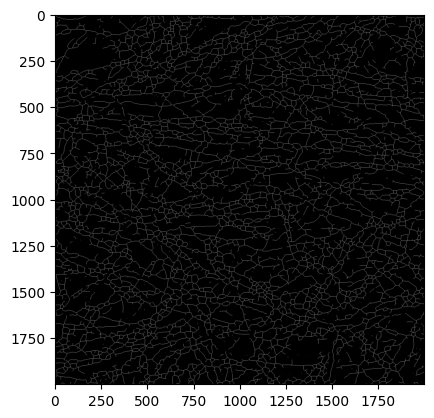

In [84]:
plt.imshow(skel_img[0:2000,0:2000], cmap='gray')

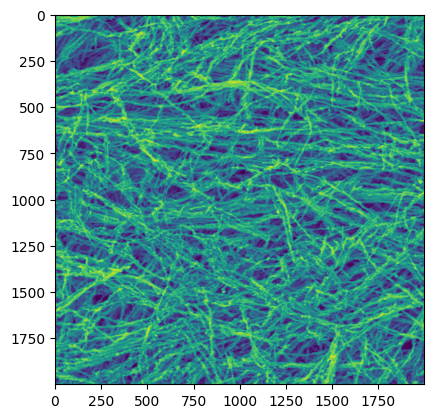

In [88]:
plt.imshow(fib_image[0:2000,0:2000])

In [ ]:
fib